In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck18
import astropy.units as u
import dataclasses
from dataclasses import dataclass
from glob import glob
import h5py
import intensity_models
from intensity_models import make_pop_model, make_pop_cosmo_model
import lal
import lalsimulation as ls
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
import re
import scipy.stats as ss
import seaborn as sns
import time
from tqdm.notebook import tqdm
from utils import pt_interp, pt_cumtrapz
import weighting

sns.set_theme('notebook', 'ticks', 'colorblind')

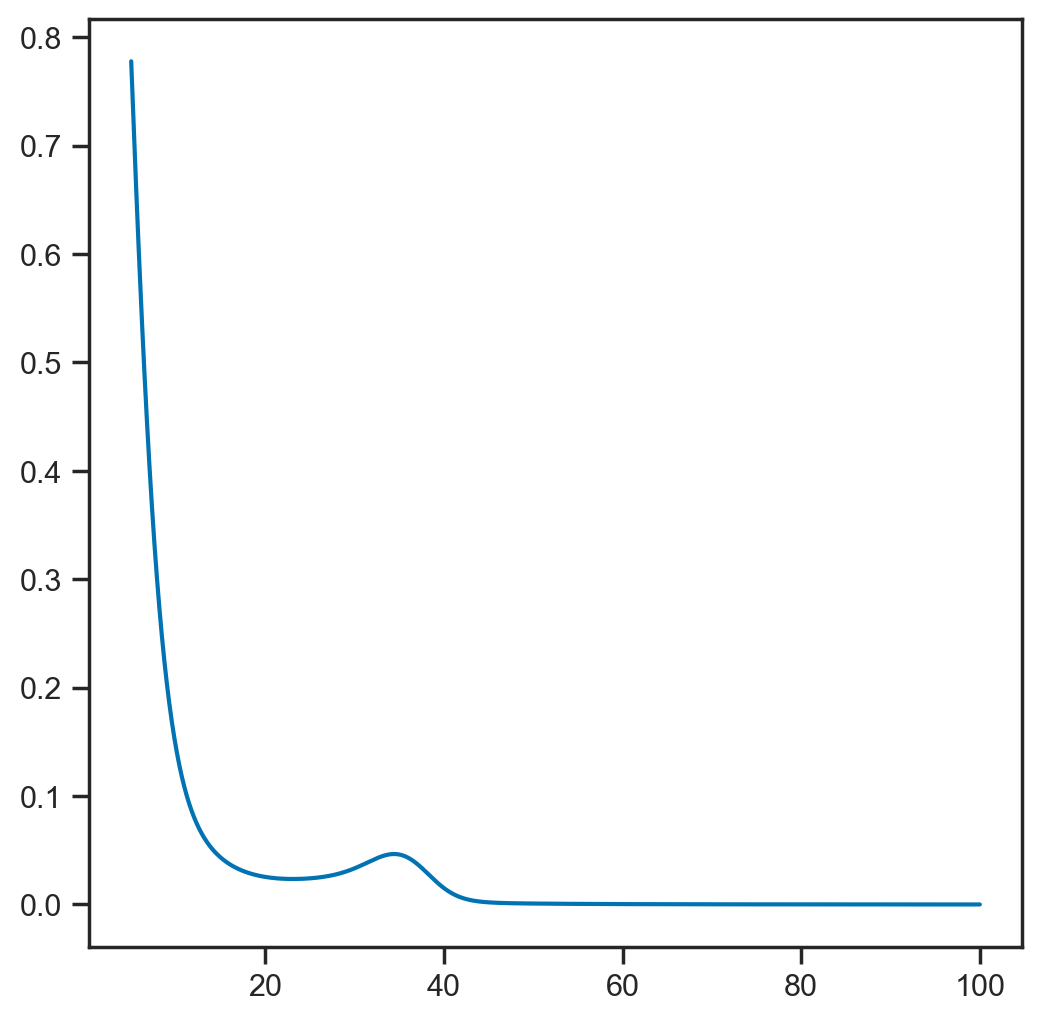

In [3]:
m = np.linspace(5, 100, 1024)
plt.plot(m, np.exp(weighting.default_log_dNdmdqdV(m, np.ones_like(m), np.zeros_like(m))))

In [4]:
inj = pd.read_hdf('../data/mock_injections.h5', key='true_parameters')

In [5]:
obs = pd.read_hdf('../data/mock_observations.h5', 'observations')
obs['m1_det'] = obs['m1']*(1 + obs['z'])
obs['dl'] = Planck18.luminosity_distance(obs['z'].to_numpy()).to(u.Gpc).value

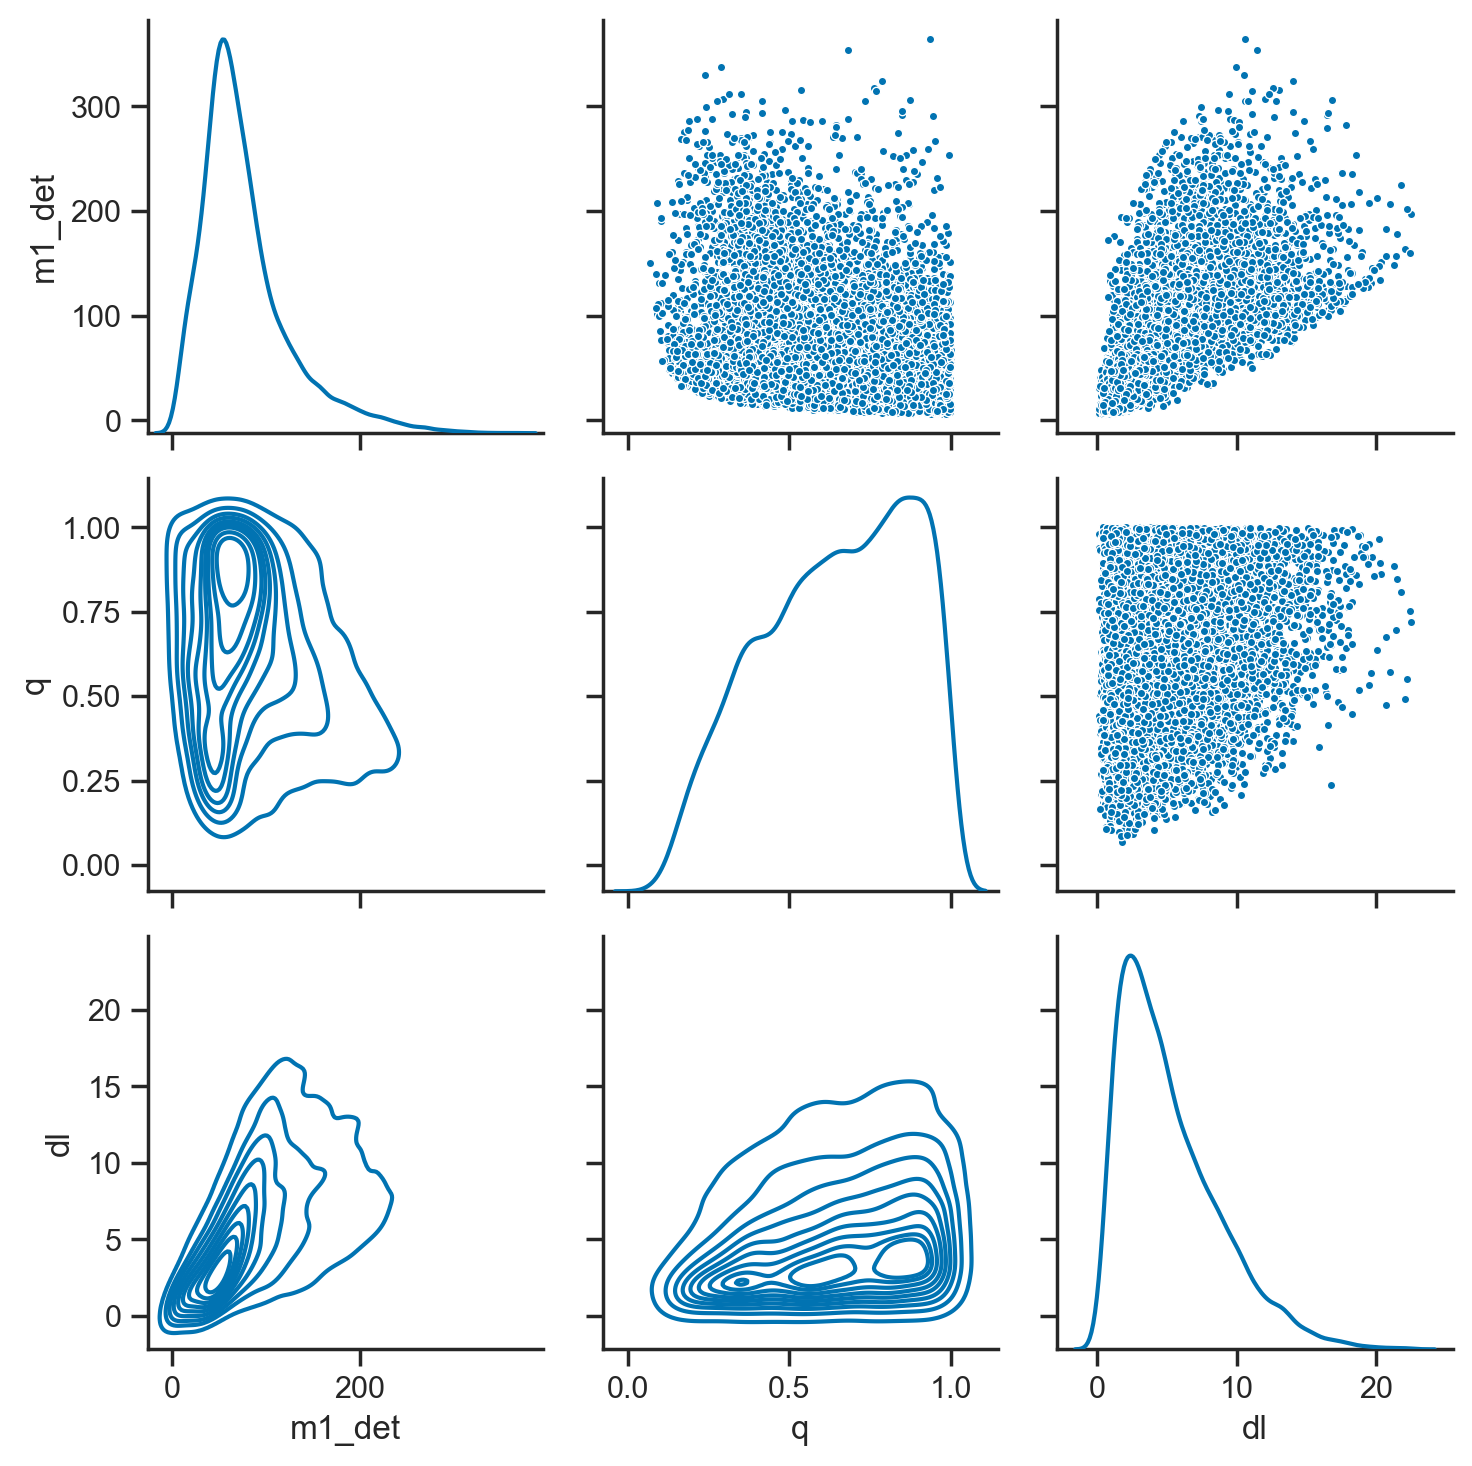

In [6]:
pg = sns.PairGrid(obs[['m1_det', 'q', 'dl']], diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot, marker='.')

In [11]:
i = np.random.randint(len(obs))
row = obs.iloc[i]
m1d, q, dl, wt = weighting.draw_mock_samples(row['log_mc_obs'], row['sigma_log_mc'], row['q_obs'], row['sigma_q'], row['log_dl_obs'], row['sigma_log_dl'], size=1000)

In [14]:
rng = np.random.default_rng()

In [18]:
?rng.integers

Docstring:
integers(low, high=None, size=None, dtype=np.int64, endpoint=False)

Return random integers from `low` (inclusive) to `high` (exclusive), or
if endpoint=True, `low` (inclusive) to `high` (inclusive). Replaces
`RandomState.randint` (with endpoint=False) and
`RandomState.random_integers` (with endpoint=True)

Return random integers from the "discrete uniform" distribution of
the specified dtype. If `high` is None (the default), then results are
from 0 to `low`.

Parameters
----------
low : int or array-like of ints
    Lowest (signed) integers to be drawn from the distribution (unless
    ``high=None``, in which case this parameter is 0 and this value is
    used for `high`).
high : int or array-like of ints, optional
    If provided, one above the largest (signed) integer to be drawn
    from the distribution (see above for behavior if ``high=None``).
    If array-like, must contain integer values
size : int or tuple of ints, optional
    Output shape.  If the given shape is,

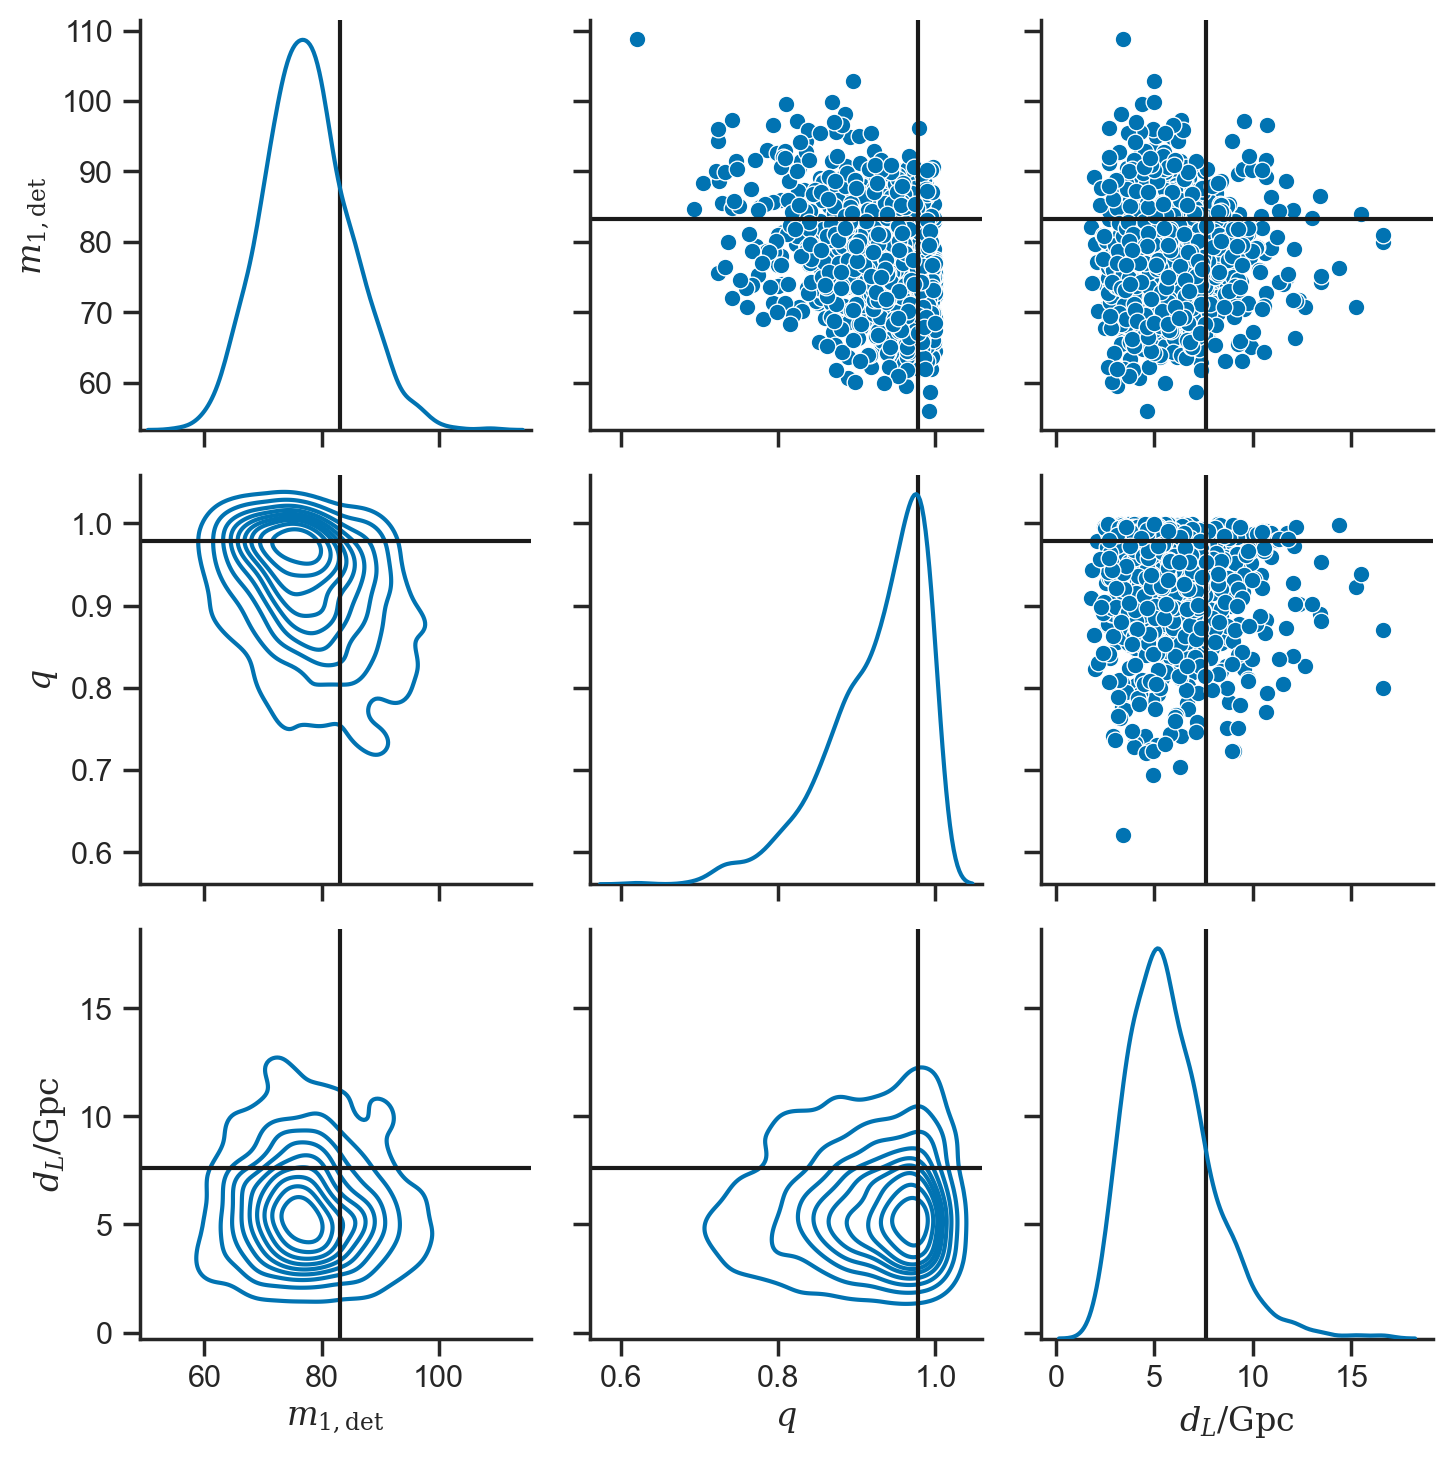

In [12]:
pg = sns.PairGrid(pd.DataFrame({r'$m_{1,\mathrm{det}}$':m1d, r'$q$':q, r'$d_L / \mathrm{Gpc}$':dl}), diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot)

for j, row_true in enumerate([row['m1_det'], row['q'], row['dl']]):
    for i, col_true in enumerate([row['m1_det'], row['q'], row['dl']]):
        if i == j:
            pg.axes[i,j].axvline(row_true, color='k')
        else:
            pg.axes[i,j].axvline(row_true, color='k')
            pg.axes[i,j].axhline(col_true, color='k')

In [13]:
np.random.SeedSequence().entropy

278954249059388231756799694135579037370